# Data Project 2021: School performance across Danish municipalities 

The aim of the data project is to investigate primary school performance across Danish municipalities based on the grade point average obtained by the students at the final exam. We fetch data for performance of primary schools from the Danish Ministry of Children and Education. Futhermore, we fetch data from Statistics Denmark covering average income levels and shares of hihgly educated inhabitants in the Danish muncipalities. First, we read and clean the data sets in order to merge them into a single DataFrame. Then, we analyze the data and investigate whether there is positive correlation between income and education levels and the performance of primary schools across municipalities. 

**The project is organized as follows:**
1. Data project description
2. Reading and cleaning data 
3. Merging data 
4. Data analysis
6. Conclusion

**Group:** SSTL

**Members:** Louise Otte Arildsen (srb330), Signe Kolind (hmk792), Stine Fürst (qvj635) & Thomas Nielsen (qzw392)

**Imports and set magics:**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn

import pandas_datareader #!pip install pandas-datareader
import pydst #!pip install git+https://github.com/elben10/pydst

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

# Read and clean data

## School performance data

**Reading and cleaning the data**<br>
We read the school data in ``Skoletal.xlsx`` obtained from [education statistics](https://uddannelsesstatistik.dk/Pages/Reports/1834.aspx) conducted by the Danish Ministry of Children and Education. The data set contains key indicators of performance for the primary schools in Denmark at municpality level. 
We clean the data by removing redundant columns and renaming the columns:

In [3]:
# a. load
school = pd.read_excel('Skoletal.xlsx', skiprows=2)

# b. drop columns
drop_these = ['Rækkenavne', 'Overgang 15 mdr ungdomsuddannelse fra 9 og 10 kl', 'Signifikant forskel', 'Forskel', 'Kompetencedækning']
school.drop(drop_these, axis=1, inplace=True)

# c. rename columns
school.rename(columns = {'Institution':'school', 'Skoleår':'year', 'Karaktergennemsnit_skoletal':'gpa', 'Socioøkonomisk reference':'socioeconomic', 'Andel med højest trivsel':'well-being', 'Samlet elevfravær':'absence', 'Elevtal':'students', 'Klassekvotient':'class'}, inplace=True)

The dataset now looks like this:

In [4]:
school.head()
#print(school.tail())

,school,year,gpa,socioeconomic,well-being,absence,students,class
0,Den Classenske Legatskole,2013/2014,8.2,7.8,NaN,NaN,500.0,24.95
1,Den Classenske Legatskole,København,8.2,7.8,NaN,NaN,500.0,24.95
2,Den Classenske Legatskole,2014/2015,7.6,7.5,0.906615,0.089829,521.0,24.90
3,Den Classenske Legatskole,København,7.6,7.5,0.906615,0.089829,521.0,24.90
4,Den Classenske Legatskole,2015/2016,8.2,8.0,0.956044,0.079799,515.0,24.90


**Seperate municipality and school year in column 'Year'**:<br>
In the data set every row is duplicated such that the data is the same in every column except from in column 'Year'. The column 'Year' alternately displays school year and municipality and we want to split this into two seperate columns. 

In [5]:
#First we check the numbers of rows in the data set school:
print(f'The number of rows in data set school is = {len(school)}')

#Then we create a new variable 'municipality', which extract allmuncipality names from 'year'
municipality=pd.DataFrame(school['year'].iloc[1::2].values)

#We check that the number of municipality names are equal to half of the row lines. 
print(f'31328 divided by 2 = {len(school)/2}')
print(f'The number of rows in data set municipality is = {len(municipality)}')

#Then we delete every other ro (then ones containing municipalities in the column 'year'
res = [True, False] * 15664
school_new=school[res]
school_new.reset_index(drop=True, inplace=True)
print(f'The number of rows in data set school_new is = {len(school_new)}')

#We then merge school_new with municipalities and arrive at the solution
school_final = pd.concat([school_new, municipality], axis=1)
school_final.tail()
school_final.rename(columns = {school_final.columns[8]:'municipality'}, inplace=True)
school_final.head()

The number of rows in data set school is = 31328
31328 divided by 2 = 15664.0
The number of rows in data set municipality is = 15664
The number of rows in data set school_new is = 15664


,school,year,gpa,socioeconomic,well-being,absence,students,class,municipality
0,Den Classenske Legatskole,2013/2014,8.2,7.8,NaN,NaN,500.0,24.95,København
1,Den Classenske Legatskole,2014/2015,7.6,7.5,0.906615,0.089829,521.0,24.90,København
2,Den Classenske Legatskole,2015/2016,8.2,8.0,0.956044,0.079799,515.0,24.90,København
3,Den Classenske Legatskole,2016/2017,7.8,7.8,0.913669,0.072769,509.0,25.60,København
4,Den Classenske Legatskole,2017/2018,8.8,8.1,0.919540,0.081672,498.0,24.80,København


In [6]:
school_final.tail()

,school,year,gpa,socioeconomic,well-being,absence,students,class,municipality
15659,Vestermarkskolen Aars,2015/2016,NaN,NaN,1.0,0.094875,49.0,NaN,Vesthimmerlands
15660,Vestermarkskolen Aars,2016/2017,NaN,NaN,1.0,0.089781,50.0,NaN,Vesthimmerlands
15661,Vestermarkskolen Aars,2017/2018,NaN,NaN,NaN,NaN,49.0,NaN,Vesthimmerlands
15662,Vestermarkskolen Aars,2018/2019,NaN,NaN,NaN,0.082224,46.0,NaN,Vesthimmerlands
15663,Vestermarkskolen Aars,2019/2020,NaN,NaN,NaN,0.085611,47.0,NaN,Vesthimmerlands


**We then only want to investigate the year 2018/2019 and rename it to 2019, since that is the 'afgangsår':**

In [7]:
school_final["year"].replace({"2018/2019": "2019", "2019/2020": "2020"}, inplace=True)

def only_keep_oneyear(df):
    """ delete all year except 2018/2019
    Args:
        df (pd.DataFrame): pandas dataframe with the column "year" as a string

    Returns:
        df (pd.DataFrame): pandas dataframe

    """ 
    for val in ['2019']:
        
        I = df.year.str.contains(val)
        df = df.loc[I == True] # keep everything else
    
    return df

school_final.year.unique()

school = only_keep_oneyear(school_final)
school.head()


,school,year,gpa,socioeconomic,well-being,absence,students,class,municipality
5,Den Classenske Legatskole,2019,7.5,7.6,0.900000,0.071541,505.0,24.75,København
12,Nyboder Skole,2019,8.0,7.8,0.950495,0.073004,524.0,22.40,København
19,Sølvgades Skole,2019,7.4,7.6,0.901961,0.071107,467.0,23.45,København
26,Nørrebro Park Skole,2019,5.3,5.5,0.950331,0.069968,741.0,24.40,København
33,Blågård Skole,2019,4.2,5.0,0.876923,0.079616,588.0,21.32,København


**DataFrame for merging is gpa mean across muncipalities, we already know it is year 2019**

In [23]:
school_merge=school.groupby(['municipality'])['gpa'].mean().reset_index(name='gpa')
school_merge.head()

,municipality,gpa
0,Aabenraa,6.127814
1,Aalborg,7.013712
2,Aarhus,7.140788
3,Albertslund,6.063983
4,Allerød,7.965370


## Income level data

**Reading and cleaning the data**<br>
* Explain where the data is fetched from and how. 
* Briefly explain what the data contains
* Explain how you clean 

In [24]:
Dst = pydst.Dst(lang='en') #

In [25]:
Dst.get_subjects()

,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,04,"Labour, income and wealth",True,True
2,06,Prices and consumption,True,True
3,05,Living conditions,True,True
4,14,National accounts and government finances,True,True
5,03,Education and knowledge,True,True
6,11,Business sectors,True,True
7,07,Business sector in general,True,True
8,16,Money and credit market,True,True
9,13,External economy,True,True


In [29]:
tables = Dst.get_tables(subjects=['04'])
tables
tables[tables.id == 'INDKP101']

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
194,INDKP101,People,-,2020-11-27 08:00:00,1987,2019,True,"[region, unit, sex, type of income, time]"


In [64]:
indk_var = Dst.get_variables(table_id='INDKP101')
indk_var

indk_var = Dst.get_variables(table_id='INDKP101')
for id in ['OMRÅDE','ENHED','KOEN','INDKOMSTTYPE', 'Tid']:
    print(id)
    values = indk_var.loc[indk_var.id == id,['values']].values[0,0]
    for value in values:      
        #print(f' id = {value["id"]}, text = {value["text"]}')

SyntaxError: unexpected EOF while parsing (<ipython-input-64-ab8e024cbf25>, line 9)

In [59]:
variables = {'OMRÅDE':['*'],'ENHED':['116'],'KOEN':['MOK'],'INDKOMSTTYPE':['105'], 'Tid':['2019']}
inc_api = Dst.get_data(table_id = 'INDKP101', variables=variables)
display(inc_api)

,OMRÅDE,ENHED,KOEN,INDKOMSTTYPE,TID,INDHOLD
0,All Denmark,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,338122
1,Province Byen København,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,353203
2,Province Københavns omegn,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,388125
3,Province Nordsjælland,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,414861
4,Province Bornholm,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,291198
...,...,...,...,...,...,...
105,Rebild,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,345560
106,Mariagerfjord,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,312392
107,Jammerbugt,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,302417
108,Aalborg,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,310886


In [73]:
inc_1=inc_api.drop(['KOEN','INDKOMSTTYPE','ENHED', 'TID'], axis=1)

inc_1.rename(columns = {'INDHOLD':'avg_income','OMRÅDE':'municipality'}, inplace=True)
display(inc_1)


,municipality,avg_income
0,All Denmark,338122
1,Province Byen København,353203
2,Province Københavns omegn,388125
3,Province Nordsjælland,414861
4,Province Bornholm,291198
...,...,...
105,Rebild,345560
106,Mariagerfjord,312392
107,Jammerbugt,302417
108,Aalborg,310886


In [110]:
avg_inc=inc_1.groupby(by="municipality").sum()
avg_inc = avg_inc.drop("All Denmark", axis=0).reset_index()
avg_inc.head()

,municipality,avg_income
0,Aabenraa,305855
1,Aalborg,310886
2,Aarhus,327869
3,Albertslund,295184
4,Allerød,437980


## Education level data

**Reading and cleaning the data**<br>
* Explain where the data is fetched from and how. 
* Briefly explain what the data contains
* Explain how you clean 


In [52]:
# List all subjects.
Dst.get_subjects()

# List all tables under the subject Education and knowledge which has the id 03\n",
table = Dst.get_tables(subjects=['03'])

#Choose the table \"HFUDD11: Befolkningens højest fuldførte uddannelse (15-69 år) efter bopælsområde, herkomst, højest fuldførte uddannelse, alder og køn\"\n",
table[table.id == 'HFUDD11']

# Get the variables in the dataset HFUDD11\n",
Edd_vars = Dst.get_variables(table_id='HFUDD11')
Edd_vars

# List all the ID of the of variable in the dataset HFUDD11:\n",
Edd_vars = Dst.get_variables(table_id='HFUDD11')
for id in ['BOPOMR','HERKOMST','HFUDD','Tid','ALDER']:
    print(id)
    values = Edd_vars.loc[Edd_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

BOPOMR
 id = 000, text = All Denmark
 id = 084, text = Region Hovedstaden
 id = 101, text = Copenhagen
 id = 147, text = Frederiksberg
 id = 155, text = Dragør
 id = 185, text = Tårnby
 id = 165, text = Albertslund
 id = 151, text = Ballerup
 id = 153, text = Brøndby
 id = 157, text = Gentofte
 id = 159, text = Gladsaxe
 id = 161, text = Glostrup
 id = 163, text = Herlev
 id = 167, text = Hvidovre
 id = 169, text = Høje-Taastrup
 id = 183, text = Ishøj
 id = 173, text = Lyngby-Taarbæk
 id = 175, text = Rødovre
 id = 187, text = Vallensbæk
 id = 201, text = Allerød
 id = 240, text = Egedal
 id = 210, text = Fredensborg
 id = 250, text = Frederikssund
 id = 190, text = Furesø
 id = 270, text = Gribskov
 id = 260, text = Halsnæs
 id = 217, text = Helsingør
 id = 219, text = Hillerød
 id = 223, text = Hørsholm
 id = 230, text = Rudersdal
 id = 400, text = Bornholm
 id = 411, text = Christiansø
 id = 085, text = Region Sjælland
 id = 253, text = Greve
 id = 259, text = Køge
 id = 350, text 

In [53]:
# Using the IDs from the previous table we get the data
variables_2 = {'BOPOMR':['*'],'HERKOMST':['*'],'HFUDD':['H10','H20','H30','H40','H50','H60','H70','H80'],'Tid':['*'],'KØN':['*'],'ALDER':['TOT']}
edu_api = Dst.get_data(table_id = 'HFUDD11', variables=variables_2)
edu_api.head(50)

,BOPOMR,HERKOMST,HFUDD,TID,KØN,ALDER,INDHOLD
0,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Women,"Age, total",5
1,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Men,"Age, total",15
2,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Total,"Age, total",20
3,Billund,Total,H10 Primary education,2008,Women,"Age, total",3565
4,Billund,Total,H10 Primary education,2008,Men,"Age, total",3489
5,Billund,Total,H10 Primary education,2008,Total,"Age, total",7054
6,Langeland,Persons of Danish origin,H40 Short cycle higher education,2008,Women,"Age, total",63
7,Langeland,Persons of Danish origin,H40 Short cycle higher education,2008,Men,"Age, total",148
8,Langeland,Persons of Danish origin,H40 Short cycle higher education,2008,Total,"Age, total",211
9,Langeland,Persons of Danish origin,H50 Vocational bachelors educations,2008,Women,"Age, total",567


In [54]:
#Drop colum ALDER and KØN
drop_these = ['ALDER','KØN']
edu_api.drop(drop_these ,axis=1,inplace=True)
edu_api.head(50)

,BOPOMR,HERKOMST,HFUDD,TID,INDHOLD
0,Haderslev,Persons of Danish origin,H80 PhD programs,2008,5
1,Haderslev,Persons of Danish origin,H80 PhD programs,2008,15
2,Haderslev,Persons of Danish origin,H80 PhD programs,2008,20
3,Billund,Total,H10 Primary education,2008,3565
4,Billund,Total,H10 Primary education,2008,3489
5,Billund,Total,H10 Primary education,2008,7054
6,Langeland,Persons of Danish origin,H40 Short cycle higher education,2008,63
7,Langeland,Persons of Danish origin,H40 Short cycle higher education,2008,148
8,Langeland,Persons of Danish origin,H40 Short cycle higher education,2008,211
9,Langeland,Persons of Danish origin,H50 Vocational bachelors educations,2008,567


In [55]:
#Translate the names of the variable to english
edu_api.rename(columns={'BOPOMR':'municipality','HERKOMST':'origin','TID':'year','HFUDD':'education','INDHOLD':'number of individuals'},inplace=True)
edu_api.head(5)

,municipality,origin,education,year,number of individuals
0,Haderslev,Persons of Danish origin,H80 PhD programs,2008,5
1,Haderslev,Persons of Danish origin,H80 PhD programs,2008,15
2,Haderslev,Persons of Danish origin,H80 PhD programs,2008,20
3,Billund,Total,H10 Primary education,2008,3565
4,Billund,Total,H10 Primary education,2008,3489


In [37]:
# Using the IDs from the previous table we get the data
variables_2 = {'BOPOMR':['*'],'HERKOMST':['TOT'],'HFUDD':['TOT','H70','H80'],'Tid':['2019'],'KØN':['TOT'],'ALDER':['TOT']}
edu_api = Dst.get_data(table_id = 'HFUDD11', variables=variables_2)
edu_api.head(5)

,BOPOMR,HERKOMST,HFUDD,TID,KØN,ALDER,INDHOLD
0,All Denmark,Total,H70 Masters programs,2019,Total,"Age, total",419094
1,All Denmark,Total,H80 PhD programs,2019,Total,"Age, total",37792
2,All Denmark,Total,Total,2019,Total,"Age, total",4040015
3,Region Nordjylland,Total,H70 Masters programs,2019,Total,"Age, total",27756
4,Region Nordjylland,Total,H80 PhD programs,2019,Total,"Age, total",2023


In [76]:
#total
total =  edu_api['HFUDD']=='Total'
print(total.head())
df_total=edu_api[total].groupby(['BOPOMR'])['INDHOLD'].sum().reset_index(name='sumtotal')

#highly
highly =  (edu_api['HFUDD']=='H70 Masters programs') | (edu_api['HFUDD']=='H80 PhD programs')
print(highly.head())
df_highly=edu_api[highly].groupby(['BOPOMR'])['INDHOLD'].sum().reset_index(name='sumhighly')

together = pd.merge(df_total, df_highly, on=['BOPOMR'], how='left')
together['highly_educ']=together['sumhighly']/together['sumtotal']


together.rename(columns = {'BOPOMR':'municipality'}, inplace=True)
together.head()

0    False
1    False
2     True
3    False
4    False
Name: HFUDD, dtype: bool
0     True
1     True
2    False
3     True
4     True
Name: HFUDD, dtype: bool


,municipality,sumtotal,sumhighly,highly_educ
0,Aabenraa,39525,1851,0.046831
1,Aalborg,156291,18722,0.119789
2,Aarhus,260373,45203,0.173609
3,Albertslund,18997,1419,0.074696
4,All Denmark,4040015,456886,0.113090


## Explore data set

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, the employment and income level in each municipality

The **static plot** is:

In [56]:
def plot_empl_inc(school,dataset,municipality): 
    
    dataset == 'School'
    df = school_final
    y = 'employment'

    
    I = df['municipality'] == municipality
    ax = df.loc[I,:].plot(x='year', y=y, style='-o')

The **interactive plot** is:

ADD SOMETHING HERE IF THE READER SHOULD KNOW THAT E.G. SOME MUNICIPALITY IS SPECIAL.

# Merge data sets

We now create a data set with **municpalities which are in both of our data sets**. We can illustrate this **merge** as:

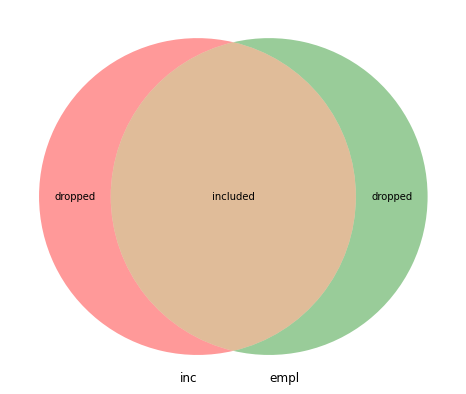

In [57]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('inc', 'empl'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

In [58]:
merged = pd.merge(empl_long, inc_long, how='inner',on=['municipality','year'])

print(f'Number of municipalities = {len(merged.municipality.unique())}')
print(f'Number of years          = {len(merged.year.unique())}')

NameError: name 'empl_long' is not defined

# Analysis

To get a quick overview of the data, we show some **summary statistics by year**:

In [ ]:
.groupby('year').agg(['mean','std']).round(2)
titanic.groupby(["Sex", "Pclass"])["Fare"].mean()

ADD FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.